## Trabajo final para la materia Vision Por Computadora 2 - Trashnet
Clasificación de residuos para reciclaje: Entrenar un modelo que, a partir de imágenes, clasifique distintos tipos de residuos (plástico, vidrio, papel, orgánicos) para optimizar procesos de reciclaje y gestión de residuos.​


Grupo: 
  - Martin Brocca
  - Emliano Iparraguirre

## 1 Análisis Exploratorio de Datos

In [48]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from pathlib import Path
import math
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import cv2
import imagehash

### 1.1 Config y utilidades

In [39]:
# ==== CONFIG ====
data_dir = "data/trashnet"  # Cambiar si corresponde
SEED = 42
IMG_SIZE_STATS = (256, 256)   # para thumbnails de stats/preview (sin usar para training)
EMBED_IMG_SIZE = 224          # tamaño para embeddings ResNet
N_SAMPLES_PREVIEW = 8         # previews por clase

random.seed(SEED)
np.random.seed(SEED)

# ==== Helpers ====
def list_images_by_class(root_dir):
    root = Path(root_dir)
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    items = []
    for cls in classes:
        for fp in (root/cls).glob("*.*"):
            if fp.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}:
                items.append({"path": str(fp), "class": cls})
    return pd.DataFrame(items)

def load_image(path, to_rgb=True):
    img = Image.open(path)
    if to_rgb and img.mode != "RGB":
        img = img.convert("RGB")
    return img

def pil_to_numpy(img):
    return np.array(img)

def show_grid(images, titles=None, cols=4, figsize=(10,8)):
    rows = math.ceil(len(images)/cols)
    plt.figure(figsize=figsize)
    for i, im in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(im)
        if titles:
            plt.title(titles[i], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()


### 1.2 Tabla resumen por clase (conteo, % y pesos sugeridos)

In [40]:
# análisis de datos, cantidad de clases y cantidad de imágenes por clase
#contar la cantidad de archivos en cada carpeta
classes = os.listdir(data_dir)
class_counts = {}
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        class_counts[cls] = len(os.listdir(class_path))
print(class_counts)

{'cardboard': 403, 'glass': 501, 'metal': 410, 'paper': 594, 'plastic': 482, 'trash': 137}


In [41]:
# mostrar algunas imágenes de ejemplo
df = list_images_by_class(data_dir)
assert len(df)>0, f"No se encontraron imágenes en {data_dir}"

class_counts = df['class'].value_counts().sort_index()
summary = pd.DataFrame({
    "class": class_counts.index,
    "count": class_counts.values
})
summary["pct"] = (summary["count"] / summary["count"].sum() * 100).round(2)
# pesos sugeridos: inversamente proporcionales a la frecuencia
summary["class_weight_suggested"] = (summary["count"].sum() / (len(summary)*summary["count"])).round(3)

summary

,class,count,pct,class_weight_suggested
0,cardboard,403,15.95,1.045
1,glass,501,19.83,0.841
2,metal,410,16.22,1.027
3,paper,594,23.51,0.709
4,plastic,482,19.07,0.874
5,trash,137,5.42,3.074


### 1.3 Histograma de distribución por clase

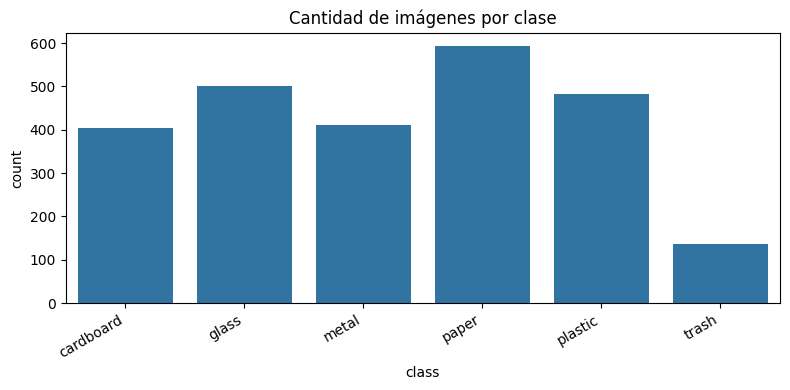

Ratio mayor/minor: 4
       class  count    pct  class_weight_suggested
0  cardboard    403  15.95                   1.045
1      glass    501  19.83                   0.841
2      metal    410  16.22                   1.027
3      paper    594  23.51                   0.709
4    plastic    482  19.07                   0.874
5      trash    137   5.42                   3.074


In [42]:
plt.figure(figsize=(8,4))
sns.barplot(x="class", y="count", data=summary)
plt.title("Cantidad de imágenes por clase")
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

print("Ratio mayor/minor:", int(summary["count"].max()/summary["count"].min()))
print(summary)


### Hay un claro desbalance de clases, con "trash" siendo la clase minoritaria


### 1.4 Previews por clase (muestras visuales)

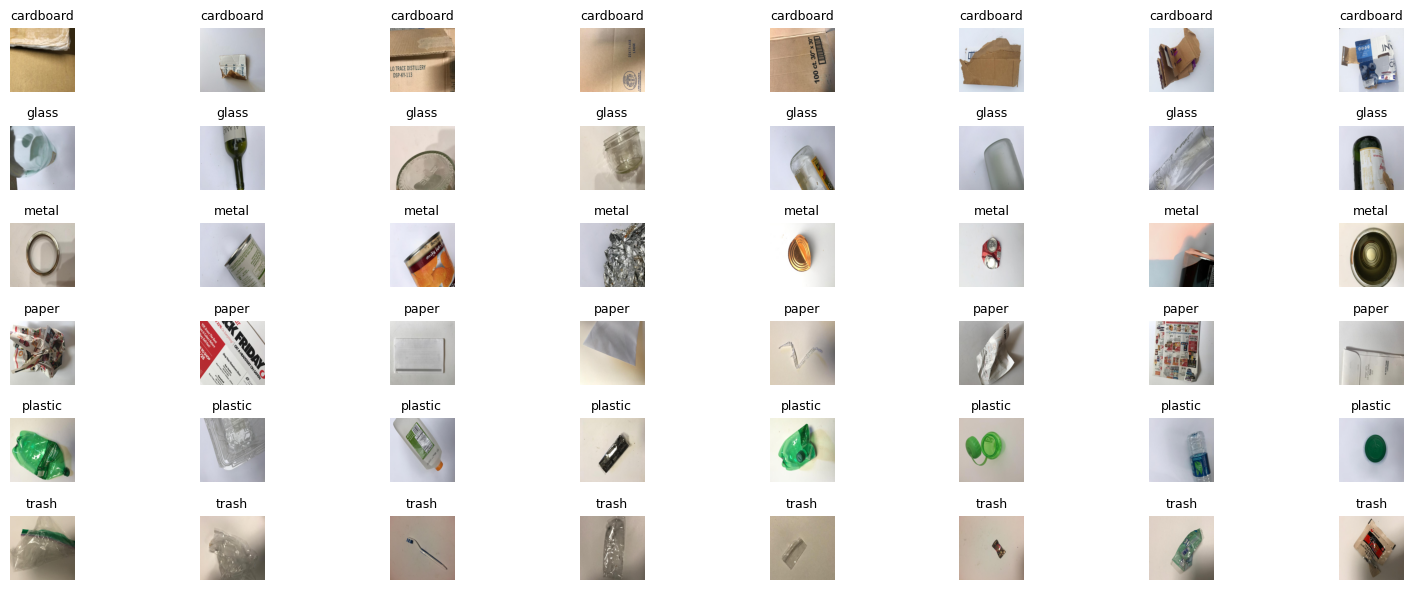

In [43]:
images, titles = [], []
for cls in summary["class"]:
    paths = df[df["class"]==cls]["path"].tolist()
    sample = random.sample(paths, k=min(N_SAMPLES_PREVIEW, len(paths)))
    for p in sample:
        img = load_image(p, to_rgb=True).resize(IMG_SIZE_STATS)
        images.append(img)
        titles.append(cls)

show_grid(images, titles, cols=8, figsize=(16, 6))

### 1.5 Tamaños / canales / aspecto

Leyendo metadata:   0%|          | 0/2527 [00:00<?, ?it/s]

Leyendo metadata: 100%|██████████| 2527/2527 [00:01<00:00, 2380.63it/s]


Modos por frecuencia:
 mode
RGB    2527
Name: count, dtype: int64
Tamaño promedio (w,h): (np.float64(512.0), np.float64(384.0))


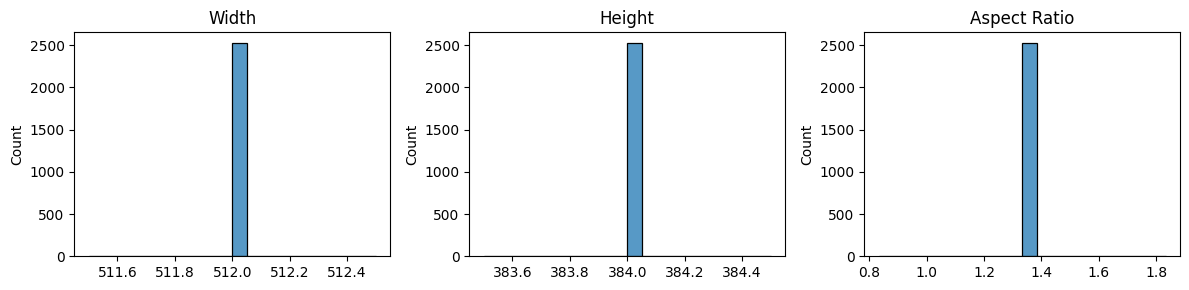

In [44]:
# Tamaños / canales / aspecto
sizes = []
modes = []
for p in tqdm(df["path"], desc="Leyendo metadata"):
    with Image.open(p) as im:
        sizes.append(im.size)   # (width, height)
        modes.append(im.mode)

sizes = np.array(sizes)
w, h = sizes[:,0], sizes[:,1]
aspect = w / h

meta = pd.DataFrame({
    "width": w, "height": h, "aspect": aspect, "mode": modes, "class": df["class"].values
})

print("Modos por frecuencia:\n", meta["mode"].value_counts())
print("Tamaño promedio (w,h):", (meta["width"].mean().round(1), meta["height"].mean().round(1)))

fig, ax = plt.subplots(1,3, figsize=(12,3))
sns.histplot(w, bins=20, ax=ax[0]); ax[0].set_title("Width")
sns.histplot(h, bins=20, ax=ax[1]); ax[1].set_title("Height")
sns.histplot(aspect, bins=20, ax=ax[2]); ax[2].set_title("Aspect Ratio")
plt.tight_layout(); plt.show()


In [45]:
#análisis de tamaño de las imágenes
image_sizes = []
for cls in classes:
    class_path = os.path.join(data_dir, cls)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = plt.imread(img_path)
            image_sizes.append(img.shape)  
image_sizes = np.array(image_sizes)
print(f'Tamaño mínimo: {image_sizes.min(axis=0)}')
print(f'Tamaño máximo: {image_sizes.max(axis=0)}')
print(f'Tamaño promedio: {image_sizes.mean(axis=0)}')


Tamaño mínimo: [384 512   3]
Tamaño máximo: [384 512   3]
Tamaño promedio: [384. 512.   3.]


**Conclusiones:**

- Todas las imágenes tienen el mismo tamaño fijo (512×384 px), en formato RGB y aspect ratio uniforme (1.33). 
- Esto facilita el preprocesamiento, dado que no es necesario unificar resoluciones ni modos de color. 
- La homogeneidad de fondo y condiciones de captura puede introducir un sesgo: el modelo podría aprender patrones del fondo en lugar de las características del residuo. 

En etapas posteriores se pueden proponer técnicas de data augmentation y, eventualmente, mezclado de fondos para mitigar este efecto.

### 1.6 Estadística de color (RGB y HSV) por clase

In [46]:
def rgb_hsv_stats(paths, n_max=200):
    # muestreamos para velocidad
    paths = paths if len(paths) <= n_max else random.sample(paths, n_max)
    rgb_means, rgb_stds, hsv_means, hsv_stds = [], [], [], []
    for p in paths:
        img = load_image(p, to_rgb=True)
        arr = np.array(img).astype(np.float32) / 255.0
        rgb_means.append(arr.mean(axis=(0,1)))
        rgb_stds.append(arr.std(axis=(0,1)))
        hsv = cv2.cvtColor((arr*255).astype(np.uint8), cv2.COLOR_RGB2HSV).astype(np.float32)/255.0
        hsv_means.append(hsv.mean(axis=(0,1)))
        hsv_stds.append(hsv.std(axis=(0,1)))
    return (np.mean(rgb_means,0), np.mean(rgb_stds,0),
            np.mean(hsv_means,0), np.mean(hsv_stds,0))

stats_rows = []
for cls in summary["class"]:
    paths = df[df["class"]==cls]["path"].tolist()
    rmean,rstd,hmean,hstd = rgb_hsv_stats(paths, n_max=300)
    stats_rows.append({
        "class": cls,
        "RGB_mean_R": rmean[0], "RGB_mean_G": rmean[1], "RGB_mean_B": rmean[2],
        "HSV_mean_H": hmean[0], "HSV_mean_S": hmean[1], "HSV_mean_V": hmean[2],
    })
color_stats = pd.DataFrame(stats_rows)
color_stats.round(3)


,class,RGB_mean_R,RGB_mean_G,RGB_mean_B,HSV_mean_H,HSV_mean_S,HSV_mean_V
0,cardboard,0.664,0.583,0.502,0.139,0.308,0.678
1,glass,0.696,0.672,0.642,0.197,0.160,0.719
2,metal,0.646,0.614,0.593,0.211,0.180,0.671
3,paper,0.677,0.647,0.611,0.131,0.144,0.687
4,plastic,0.672,0.667,0.660,0.277,0.129,0.708
5,trash,0.701,0.651,0.585,0.081,0.196,0.705


### 1.6 Estadística de color (RGB y HSV) por clase

El análisis de medias por canal RGB y HSV muestra lo siguiente:

- **RGB**:
  - Las clases presentan **diferencias visibles en intensidad de color**.
  - `Cardboard` y `trash` tienden a valores más altos en el canal **R**, reflejando tonos rojizos/marrones.
  - `Glass` y `plastic` destacan por tener valores más altos en **G y B**, lo que sugiere tonalidades más claras o azuladas.
  - `Metal` y `paper` quedan en valores intermedios, con distribuciones más equilibradas.

- **HSV (Hue, Saturation, Value)**:
  - El **Hue (H)** muestra cierta capacidad discriminante:
    - `Plastic` tiene el valor más alto (~0.27), indicando mayor variación hacia tonos azulados.
    - `Trash` el más bajo (~0.08), más cercano a tonalidades rojizas/marrones.
  - La **Saturación (S)** es baja en general (<0.31), lo que refleja que las imágenes tienen colores poco saturados (fondo claro y objetos simples).
  - El **Value (V)** es relativamente alto en todas las clases (>0.67), consistente con la presencia de un **fondo mayormente blanco/claro**.

- **Conclusiones**:
  - El color aporta cierta información útil, pero la baja saturación y el brillo alto homogéneo hacen que **los objetos puedan confundirse si el modelo se apoya demasiado en características de color**.
  - Se podría esperar que clases como `glass` vs `plastic` y `paper` vs `cardboard` sean las más confusas debido a similitudes en distribuciones de color.
  
  Este análisis refuerza la necesidad de aplicar **data augmentation** (cambios de iluminación, jitter de color) para que el modelo aprenda características más robustas y no dependa exclusivamente de patrones de color y brillo.

### 1.7 Chequeo simple de “fondo blanco” (sesgo)

In [47]:
def white_background_ratio(img_pil, v_thresh=0.92, s_thresh=0.2):
    # porcentaje de píxeles con alto V (brillo) y baja saturación (fondo claro)
    arr = np.array(img_pil.convert("RGB"))
    hsv = cv2.cvtColor(arr, cv2.COLOR_RGB2HSV).astype(np.float32)/255.0
    H,S,V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]
    mask = (V >= v_thresh) & (S <= s_thresh)
    return mask.mean()

bg_rows = []
for cls in summary["class"]:
    paths = df[df["class"]==cls]["path"].tolist()
    paths = random.sample(paths, k=min(150, len(paths)))
    ratios = [white_background_ratio(load_image(p)) for p in paths]
    bg_rows.append({"class": cls, "bg_white_ratio_mean": np.mean(ratios), "bg_white_ratio_std": np.std(ratios)})
bg_df = pd.DataFrame(bg_rows)
bg_df.sort_values("bg_white_ratio_mean", ascending=False).round(3)


,class,bg_white_ratio_mean,bg_white_ratio_std
2,metal,0.100,0.129
1,glass,0.092,0.110
3,paper,0.064,0.061
0,cardboard,0.060,0.100
5,trash,0.055,0.091
4,plastic,0.035,0.078


El análisis de la proporción de píxeles con fondo claro (alto valor de brillo y baja saturación) muestra que:

- **Resultados por clase**:
  - `Metal` (0.10) y `glass` (0.09) son las clases con mayor proporción de fondo blanco.
  - `Paper` (0.06) y `cardboard` (0.06) presentan valores intermedios.
  - `Trash` (0.055) y `plastic` (0.035) son las que menos porcentaje de fondo blanco tienen.

- **Variabilidad (std)**:
  - Los desvíos estándar son relativamente bajos (<0.13), indicando que la presencia de fondo blanco es bastante consistente dentro de cada clase.
  - Sin embargo, existen diferencias notables entre clases, lo cual puede convertirse en un **sesgo para el modelo**: este podría aprender a asociar ciertas categorías más con el fondo que con el objeto en sí.

- **Conclusiones**:
  - La mayoría de las imágenes tienen algún grado de fondo blanco, lo que confirma la **homogeneidad del dataset en condiciones de captura**.
  - Existe un riesgo de que el modelo clasifique apoyándose en la proporción de fondo blanco en lugar de en las características intrínsecas del objeto.
  - Este hallazgo refuerza la importancia de aplicar **data augmentation** (cambios de fondo, recortes, jitter de color) o técnicas de segmentación/recorte, para evitar que el modelo se sesgue hacia el contexto.

### 1.8 Duplicados / casi-duplicados con perceptual hash

In [ ]:
# Lo aplicamos sobre las 2527 imágenes (tarda un poco)
MAX_HASH = 2527
sample_df = df.sample(n=min(MAX_HASH, len(df)), random_state=SEED).reset_index(drop=True)

hashes = []
for p in tqdm(sample_df["path"], desc="Hashing"):
    img = load_image(p).resize((256,256))
    h = imagehash.phash(img)   # perceptual hash
    hashes.append(str(h))
sample_df["phash"] = hashes

dup_groups = sample_df.groupby("phash").filter(lambda g: len(g)>1).sort_values("phash")
dup_groups.head(10)


Hashing: 100%|██████████| 2527/2527 [00:12<00:00, 204.31it/s]


,path,class,phash
1081,data\trashnet\plastic\plastic152.jpg,plastic,95e5f8aa074b264d
2323,data\trashnet\glass\glass176.jpg,glass,95e5f8aa074b264d
268,data\trashnet\paper\paper101.jpg,paper,bbf8d0e08723d364
2041,data\trashnet\paper\paper108.jpg,paper,bbf8d0e08723d364
501,data\trashnet\paper\paper308.jpg,paper,e6ea9183b823b2ad
1774,data\trashnet\paper\paper305.jpg,paper,e6ea9183b823b2ad
1554,data\trashnet\glass\glass389.jpg,glass,ea4e91b5873292b6
2123,data\trashnet\plastic\plastic332.jpg,plastic,ea4e91b5873292b6
1537,data\trashnet\glass\glass115.jpg,glass,f363092c63337b89
1897,data\trashnet\metal\metal91.jpg,metal,f363092c63337b89


### 1.8 Duplicados / casi-duplicados con perceptual hash (dataset completo)

Se aplicó el hashing perceptual (pHash) sobre **todas las imágenes del dataset (2527)** para identificar duplicados o imágenes muy similares.

- **Resultado**:
  - Se detectaron algunos pares de imágenes con el mismo valor de hash.
  - Ejemplos encontrados:
    - `plastic152.jpg` y `glass176.jpg` comparten el mismo hash. Muestran un frasco (vidrio) y una botella (plástico) que son muy similares
    - `paper101.jpg` y `paper108.jpg`.
    - `paper308.jpg` y `paper305.jpg`.
    - `glass389.jpg` y `plastic332.jpg`.
    - `glass115.jpg` y `metal91.jpg`.
  - Esto indica que existen **imágenes duplicadas o muy similares**, incluso **entre clases diferentes**.

- **Implicancias**:
  - Si duplicados aparecen **dentro de la misma clase**, el impacto es bajo (solo reducen diversidad).
  - Si aparecen **entre clases distintas**, existe riesgo de **ruido o errores de etiquetado**: el modelo podría confundirse si imágenes casi idénticas tienen etiquetas diferentes.
  - Además, si duplicados se reparten entre *train* y *test*, se puede generar **data leakage** que infle artificialmente el rendimiento.

- **Conclusiones**:
  - El dataset TrashNet presenta un pequeño número de duplicados/casi-duplicados.

  - Recomendación para seguir luego:
    - Revisar manualmente los casos entre clases distintas (*ej. glass vs plastic, glass vs metal*).
    - Asegurar que, al generar splits, imágenes con el mismo hash no se dividan entre train/val/test.
    - Considerar eliminarlos o consolidarlos para aumentar la limpieza del dataset.